In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
torch.cuda.is_available()

True

## Load and normalize dataset

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
y_train = np.array(train_data["label"])
x_train = np.array(train_data.drop(columns=["label"]))
x_train = x_train / 255.0
x_test = test_data / 255.0

0


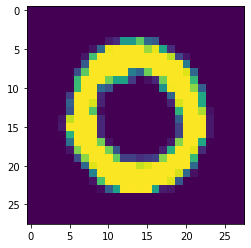

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1].reshape(28,28))
print(y_train[1])

In [5]:
x_train.shape

(42000, 784)

In [6]:
x_train = x_train.reshape(42000, 28, 28).astype('float32')

In [7]:
train_images_tensor = torch.tensor(x_train).cuda()
train_labels_tensor = torch.tensor(y_train).cuda()

train_images_tensor = train_images_tensor.view(-1, 1, 28, 28).float()

train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

In [8]:
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(x_test, batch_size=64, shuffle=False)

## Define a model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = MnistModel()
print(model)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 170, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 170, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
RuntimeError: CUDA error: initialization error


In [ ]:
#loss funtion and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data[0], float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [ ]:
fit(model, train_loader)

In [ ]:
EPOCHS = 5

def train_model(EPOCHS):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))
        

In [ ]:
# num_epochs = 5

# for n in range(EPOCHS):
#     train_model(n)